# Постановка задачи

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

# Подготовка

In [ ]:
import pandas as pd
import requests as rq
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
olist_customers_datase_public_key = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_orders_dataset_public_key = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_order_items_dataset_public_key = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

download_url_olist_customers_datase =\
            rq.get(base_url + urlencode(dict(public_key=olist_customers_datase_public_key)))\
            .json()['href']

download_url_olist_orders_dataset =\
            rq.get(base_url + urlencode(dict(public_key=olist_orders_dataset_public_key)))\
            .json()['href']

download_url_olist_order_items_dataset =\
            rq.get(base_url + urlencode(dict(public_key=olist_order_items_dataset_public_key)))\
            .json()['href']

# читаем csv'шки по полученным ссылкам
customers = pd.read_csv(download_url_olist_customers_datase)
orders = pd.read_csv(download_url_olist_orders_dataset)
order_items = pd.read_csv(download_url_olist_order_items_dataset)

# приводим соответствующие колонки в формат даты  
orders[['order_purchase_timestamp',\
        'order_approved_at',\
        'order_delivered_carrier_date',\
        'order_delivered_customer_date',\
        'order_estimated_delivery_date']] =\
orders[['order_purchase_timestamp',\
        'order_approved_at',\
        'order_delivered_carrier_date',\
        'order_delivered_customer_date',\
        'order_estimated_delivery_date']]\
        .apply(pd.to_datetime)

order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date)

# Описание полей

 customers — таблица с уникальными идентификаторами пользователей
* customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

* customer_unique_id —  уникальный идентификатор пользователя

* customer_zip_code_prefix —  почтовый индекс пользователя

* customer_city —  город доставки пользователя

* customer_state —  штат доставки пользователя

orders —  таблица заказов

* order_id —  уникальный идентификатор заказа (номер чека)

* customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

* order_status —  статус заказа

* order_purchase_timestamp —  время создания заказа

* order_approved_at —  время подтверждения оплаты заказа

* order_delivered_carrier_date —  время передачи заказа в логистическую службу

* order_delivered_customer_date —  время доставки заказа

* order_estimated_delivery_date —  обещанная дата доставки

order_items —  товарные позиции, входящие в заказы

* order_id —  уникальный идентификатор заказа (номер чека)

* order_item_id —  идентификатор товара внутри одного заказа

* product_id —  ид товара (аналог штрихкода)

* seller_id — ид производителя товара

* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

* price —  цена за единицу товара

* freight_value —  вес товара

# Решение

# 1

Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [3]:
# Объясню ход мыслей: с точки зрения законодательства РФ (и, пожалуй, большей части стран) покупка считается совершенной
# после получения покупателем чека, т.е. после оплаты. В описании к заданию указано, что order_approved_at это время 
# подтверждения оплаты заказа, но следующий статус - invoiced (выставлен счёт). Мне кажется, что не может быть произведена оплата
# до выставления счета, а статус approved - это подтверждение состава заказа клиентом. Таким образом, данных об оплате мы 
# не получили, однако смело можно опираться на статус заказа. Поэтому, статусы created, approved и invoiced мы не берем в расчет, 
# т.к. оплата происходит позже, статусы unavailable и canceled, соответственно, тоже, т.к. покупка не состоялась. 
# Поэтому я оставил в запросе статусы processing, shipped и delivered, т.к. оплата уже произведена, а заказ либо доставлен, 
# либо уже в пути. Дальше дело техники - иннерджойним таблицы customers и orders по столбцу customer_id, группируем по 
# customer_unique_id, считаем для каждого айди кол-во заказов и отбираем строки, где оно равно 1, выводим количество строк.
customers[['customer_id', 'customer_unique_id']]\
            .merge(
                    orders\
                            .query('order_status in ("processing", "shipped", "delivered")')\
                            [['customer_id', 'order_id']],
                            on='customer_id'
                  )\
                    .groupby('customer_unique_id', as_index=False)\
                    .agg({'order_id': 'count'})\
                    .rename(columns={'order_id': 'orders_quantity'})\
                    .query('orders_quantity == 1')\
                    .shape[0]


91814

# 2

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [9]:
# Ход мыслей следующий: причин невыполненной доставки может быть 2 - отмена заказа клиентом или невозможность выполнения заказа
# (например, если клиент не выходит на связь или не может произвести оплату), для этих случаев подходят статусы unavailable и 
# canceled. Также я добавил условие 'order_delivered_customer_date == "NaT"', т.к. есть несколько заказов с выполненной 
# доставкой со статусом canceled, но технически они не подходят под наши условия, поэтому я их не учитывал

# Здесь считаем среднее кол-во всех невыполненных доставок в месяц, получаем около 47
round(
      orders
            .query('order_delivered_customer_date == "NaT" and order_status in ("unavailable", "canceled")')
            .set_index('order_purchase_timestamp')
            .resample('MS')
            .order_id
            .count()
            .mean(), 
    2)

47.23

In [10]:
# Здесь разбиваем невыполненные доставки на причины - canceled или unavailable, если проверить методом mean или describe,
# то в сумме средних значений получаем те же ~ 47 невыполненных доставок в месяц
non_delivered =\
                orders\
                        .query('order_delivered_customer_date == "NaT" and order_status in ("unavailable", "canceled")')\
                        .groupby(['order_purchase_timestamp', 'order_status'], as_index=False)\
                        .agg({'order_id': 'count'})\
                        .pivot(index='order_purchase_timestamp', columns='order_status', values='order_id')\
                        .resample('MS')\
                        .count()\
                #         .describe()
non_delivered

order_status              canceled  unavailable
order_purchase_timestamp                       
2016-09-01                       2            0
2016-10-01                      19            7
2016-11-01                       0            0
2016-12-01                       0            0
2017-01-01                       3           10
2017-02-01                      17           45
2017-03-01                      33           32
2017-04-01                      18            9
2017-05-01                      29           31
2017-06-01                      16           24
2017-07-01                      28           51
2017-08-01                      27           32
2017-09-01                      20           38
2017-10-01                      26           58
2017-11-01                      37           83
2017-12-01                      11           42
2018-01-01                      34           48
2018-02-01                      72           30
2018-03-01                      26           17
2018-04-01                      15            5
2018-05-01                      24           16
2018-06-01                      18            4
2018-07-01                      41           18
2018-08-01                      84            7
2018-09-01                      15            0
2018-10-01                       4            0

In [11]:
print(f'Невыполненых доставок в среднем по причине отмены заказа - {round(non_delivered.canceled.mean(), 1)}, по причине недоступности клиента {round(non_delivered.unavailable.mean(), 1)}')

Невыполненых доставок в среднем по причине отмены заказа - 23.8, по причине недоступности клиента 23.3


Text(0, 0.5, 'Количество')

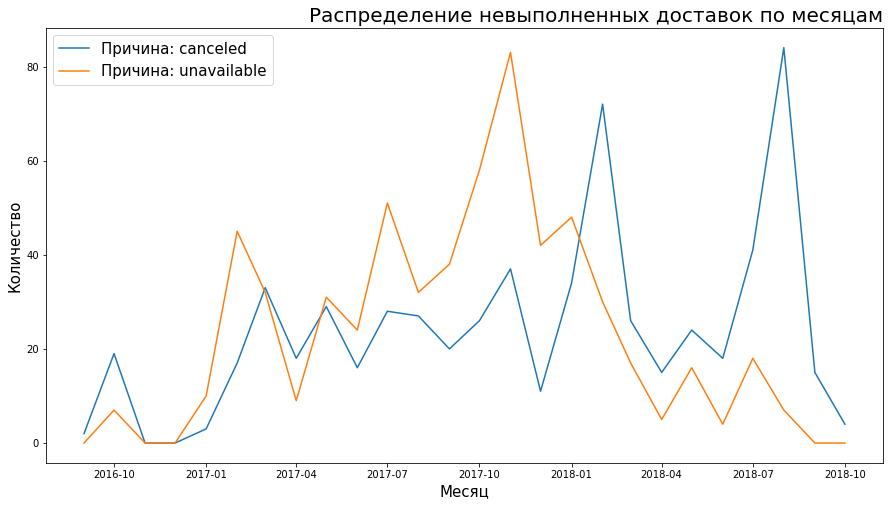

In [12]:
non_delivered_per_month = orders\
                            .query('order_delivered_customer_date == "NaT" and order_status in ("unavailable", "canceled")')\
                            .groupby(['order_purchase_timestamp', 'order_status'], as_index=False)\
                            .agg({'order_id': 'count'})\
                            .pivot(index='order_purchase_timestamp', columns='order_status', values='order_id')\
                            .resample('MS')\
                            .count()\
                            .reset_index()

f, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='order_purchase_timestamp', y='canceled', data=non_delivered_per_month, label='Причина: canceled')
sns.lineplot(x='order_purchase_timestamp', y='unavailable', data=non_delivered_per_month, label='Причина: unavailable')
plt.legend(loc=2, prop={'size': 15})
plt.title('Распределение невыполненных доставок по месяцам', loc='right', fontsize=20)
ax.set_xlabel('Месяц', fontsize=15)
ax.set_ylabel('Количество', fontsize=15)

# 3

По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [13]:
# Фильтрация по статусу заказа не требуется, т.к. важен именно порыв клиента купить что-то в определенный день
# Группируем order_items по номеру заказа, для каждого создаем список product_id входящих в заказ
# Иннерджойним с отобранными колонками из orders, и "взрываем" product_id, чтобы для каждого продукта получить строку с
# датой и временем заказа. Из колонки с датой получаем день недели, переименовываем ее для соответствия с действительностью.
prod_purchase_date = \
    order_items\
            .groupby('order_id', as_index=False)\
            .agg({'product_id': list})\
            .merge(orders[['order_id', 'order_purchase_timestamp']], on='order_id')\
            .explode('product_id')

prod_purchase_date['order_purchase_timestamp'] = prod_purchase_date['order_purchase_timestamp'].dt.day_name()
prod_purchase_date.rename(columns={'order_purchase_timestamp': 'day_of_week'},inplace=True)
prod_purchase_date

order_id                        product_id  \
0      00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1      00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2      000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3      00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4      00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                 ...                               ...   
98661  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
98662  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
98663  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
98664  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
98665  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

      day_of_week  
0       Wednesday  
1       Wednesday  
2          Sunday  
3       Wednesday  
4        Saturday  
...           ...  
98661      Monday  
98662    Saturday  
98663      Monday  
98664      Monday  
98665    Saturday  

[112650 rows x 3 columns]

In [14]:
# Группируем по product_id, считаем встречаемость дней недели, удаляем лишнюю колонку, удаляем дубли по колонке product_id,
# т.к. для каждого продукта у нас в первой строке искомый день недели с максимальным количеством заказов, 
# а остальные нас не интересуют, удаляем лишнюю колонку

prod_purchase_date\
                    .groupby('product_id')\
                    .day_of_week\
                    .value_counts()\
                    .to_frame()\
                    .rename(columns={'day_of_week': 'quantity'})\
                    .reset_index()\
                    .drop_duplicates(subset='product_id')\
                    .reset_index(drop=True)\
                    .drop(columns='quantity')

product_id day_of_week
0      00066f42aeeb9f3007548bb9d3f33c38      Sunday
1      00088930e925c41fd95ebfe695fd2655     Tuesday
2      0009406fd7479715e4bef61dd91f2462    Thursday
3      000b8f95fcb9e0096488278317764d19      Friday
4      000d9be29b5207b54e86aa1b1ac54872     Tuesday
...                                 ...         ...
32946  fff6177642830a9a94a0f2cba5e476d1    Saturday
32947  fff81cc3158d2725c0655ab9ba0f712c      Monday
32948  fff9553ac224cec9d15d49f5a263411f      Friday
32949  fffdb2d0ec8d6a61f0a0a0db3f25b441     Tuesday
32950  fffe9eeff12fcbd74a2f2b007dde0c58   Wednesday

[32951 rows x 2 columns]

Text(0, 0.5, 'Количество покупок')

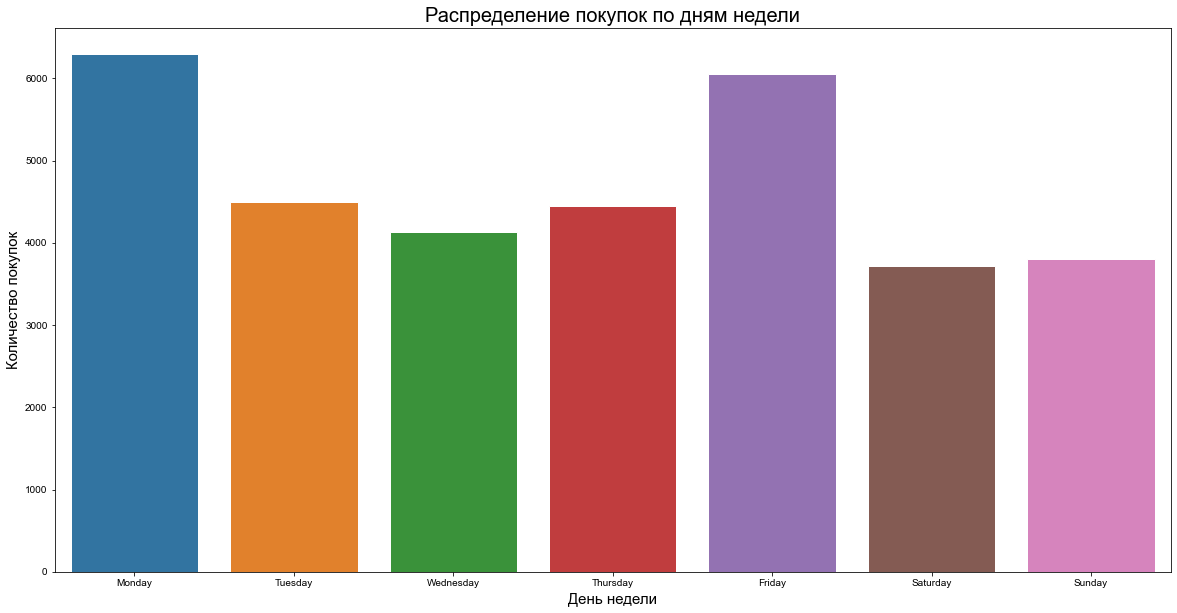

In [15]:
# Настает время визуализации
for_countplot = prod_purchase_date\
                    .groupby('product_id')\
                    .day_of_week\
                    .value_counts()\
                    .to_frame()\
                    .rename(columns={'day_of_week': 'quantity'})\
                    .reset_index()\
                    .drop_duplicates(subset='product_id')\
                    .reset_index(drop=True)\
                    .drop(columns='quantity')

f, ax = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')
sns.countplot(
    x='day_of_week', 
    data=for_countplot, 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
             )
plt.title('Распределение покупок по дням недели', loc='center', fontsize=20)
ax.set_xlabel('День недели', fontsize=15)
ax.set_ylabel('Количество покупок', fontsize=15)

# 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [16]:
# Иннерджойним таблицы customers и orders
# Речь идет о покупках, поэтому используем фильтр по статусу заказа, как в первом задании
cust_date = customers[['customer_id', 'customer_unique_id']]\
                        .merge(
                                orders[['customer_id', 'order_purchase_timestamp', 'order_status']]\
                                .query('order_status in ("processing", "shipped", "delivered")'), 
                                on='customer_id'
                              )
# Создаем колонку с месяцем, забирая нужные цифры из нашей даты
cust_date['purchase_month'] = cust_date.order_purchase_timestamp.dt.strftime('%Y-%m')

In [17]:
# Группируем по клиентам и месяцам, считаем количество заказов, переименовываем колонку
cust_date_2 = cust_date.groupby(['customer_unique_id', 'purchase_month'], as_index=False)\
                       .agg({'customer_id': 'count'})\
                       .rename(columns={'customer_id': 'buys'})


In [18]:
# Создаем функцию, считающую кол-во недель в месяце
def weeks_counter(x):
    if x[5:] in ('01', '03', '05', '07', '08', '10', '12'):
        res = 31
    elif x[5:] in ('04', '06', '09', '11'):
        res = 30
    else:
        res = 28
    return round(res/7, 2)

In [19]:
# Создаем с помощью функции новую колонку с кол-вом недель
cust_date_2['weeks_num'] = cust_date_2.purchase_month.apply(weeks_counter)
# Создаем искомую колонку с метрикой путем деления кол-ва покупок за месяц на кол-во недель в этом месяце
cust_date_2['avg_buys_per_week'] = round(cust_date_2.buys/cust_date_2.weeks_num, 2)
# Для наглядности закидываем месяц и клиента в индекс, сортируем в обратном хронологическом порядке
cust_date_2\
            .set_index(['purchase_month', 'customer_unique_id'])\
            .avg_buys_per_week\
            .to_frame()\
            .sort_index(ascending=False)

avg_buys_per_week
purchase_month customer_unique_id                                 
2018-09        ff22e30958c13ffe219db7d711e8f564               0.23
2018-08        fff96bc586f78b1f070da28c4977e810               0.23
               ffec490ab531184a483efe2eedd68908               0.23
               ffe204b1bb8026741b839085b2fd10f2               0.23
               ffc4e1cd8aa220763480d0a18157c45d               0.23
...                                                            ...
2016-10        0313291a6f4f16df04dcf819d88c38ef               0.23
               01f156677184504063bd19739f924af1               0.23
               0032c76b20340da25249092a268ce66c               0.23
2016-09        b7d76e111c89f7ebf14761390f0f7d17               0.23
               830d5b7aaa3b6f1e9ad63703bec97d23               0.23

[96559 rows x 1 columns]

In [20]:
# Еще один вариант представления этих же данных, Nan'ы заполняем нулями
cust_date_2\
            .pivot(
                index='customer_unique_id', 
                columns='purchase_month', 
                values='avg_buys_per_week'
                  )\
            .fillna(0)
#             .fillna('')

purchase_month                    2016-09  2016-10  2016-12  2017-01  2017-02  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      0.0      0.0      0.0      0.0     0.00   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0      0.0      0.0      0.0     0.00   
0000f46a3911fa3c0805444483337064      0.0      0.0      0.0      0.0     0.00   
0000f6ccb0745a6a4b88665a16c9f078      0.0      0.0      0.0      0.0     0.00   
0004aac84e0df4da2b147fca70cf8255      0.0      0.0      0.0      0.0     0.00   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0      0.0      0.0      0.0     0.00   
fffea47cd6d3cc0a88bd621562a9d061      0.0      0.0      0.0      0.0     0.00   
ffff371b4d645b6ecea244b27531430a      0.0      0.0      0.0      0.0     0.25   
ffff5962728ec6157033ef9805bacc48      0.0      0.0      0.0      0.0     0.00   
ffffd2657e2aad2907e67c3e9daecbeb      0.0      0.0      0.0      0.0     0.00   

purchase_month                    2017-03  2017-04  2017-05  2017-06  2017-07  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2     0.00      0.0     0.00     0.00      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     0.00      0.0     0.00     0.00      0.0   
0000f46a3911fa3c0805444483337064     0.23      0.0     0.00     0.00      0.0   
0000f6ccb0745a6a4b88665a16c9f078     0.00      0.0     0.00     0.00      0.0   
0004aac84e0df4da2b147fca70cf8255     0.00      0.0     0.00     0.00      0.0   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684     0.00      0.0     0.00     0.23      0.0   
fffea47cd6d3cc0a88bd621562a9d061     0.00      0.0     0.00     0.00      0.0   
ffff371b4d645b6ecea244b27531430a     0.00      0.0     0.00     0.00      0.0   
ffff5962728ec6157033ef9805bacc48     0.00      0.0     0.00     0.00      0.0   
ffffd2657e2aad2907e67c3e9daecbeb     0.00      0.0     0.23     0.00      0.0   

purchase_month                    ...  2017-12  2018-01  2018-02  2018-03  \
customer_unique_id                ...                                       
0000366f3b9a7992bf8c76cfdf3221e2  ...     0.00      0.0      0.0      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...     0.00      0.0      0.0      0.0   
0000f46a3911fa3c0805444483337064  ...     0.00      0.0      0.0      0.0   
0000f6ccb0745a6a4b88665a16c9f078  ...     0.00      0.0      0.0      0.0   
0004aac84e0df4da2b147fca70cf8255  ...     0.00      0.0      0.0      0.0   
...                               ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684  ...     0.00      0.0      0.0      0.0   
fffea47cd6d3cc0a88bd621562a9d061  ...     0.23      0.0      0.0      0.0   
ffff371b4d645b6ecea244b27531430a  ...     0.00      0.0      0.0      0.0   
ffff5962728ec6157033ef9805bacc48  ...     0.00      0.0      0.0      0.0   
ffffd2657e2aad2907e67c3e9daecbeb  ...     0.00      0.0      0.0      0.0   

purchase_month                    2018-04  2018-05  2018-06  2018-07  2018-08  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      0.0     0.23      0.0      0.0      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0     0.23      0.0      0.0      0.0   
0000f46a3911fa3c0805444483337064      0.0     0.00      0.0      0.0      0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0     0.00      0.0      0.0      0.0   
0004aac84e0df4da2b147fca70cf8255      0.0     0.00      0.0      0.0      0.0   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0     0.00      0.0      0.0      0.0   
fffea47cd6d3cc0a88bd621562a9d061      0.0     0.00      0.0      0.0      0.0   
ffff371b4d645b6ecea244b27531430a      0.0     0.00      0.0      0.0      0.0   

# Дополнение

In [21]:
# Выведу эту же метрику для кол-ва товаров в заказе
# Здесь так же джойним customers к orders, и в добавок джойним к ним order_items, сгруппированную и аггрегированную 
# по кол-ву товаров в заказе
cust_prod = customers[['customer_id', 'customer_unique_id']]\
                        .merge(
                                orders[['customer_id', 'order_purchase_timestamp', 'order_status', 'order_id']]\
                                .query('order_status in ("processing", "shipped", "delivered")'), 
                                on='customer_id'
                              )\
                                .merge(
                                        order_items\
                                                    .groupby('order_id', as_index=False)\
                                                    .agg({'product_id': 'count'})\
                                                    .rename(columns={'product_id': 'buys'}),
                                                    on='order_id'
                                      )
# Так же добавляем колонку с месяцем
cust_prod['purchase_month'] = cust_prod.order_purchase_timestamp.dt.strftime('%Y-%m')
# Сразу скидываем все ненужные колонки
cust_prod.drop(columns=['order_purchase_timestamp', 'order_status', 'order_id', 'customer_id'], inplace=True)

In [22]:
# Группируем по месяцу и клиенту, только на этот раз считаем уже сумму
cust_prod_2 = cust_prod\
                        .groupby(['purchase_month', 'customer_unique_id'], as_index=False)\
                        .agg({'buys': 'sum'})

# Создаем с помощью функции новую колонку с кол-вом недель
cust_prod_2['weeks_num'] = cust_prod_2.purchase_month.apply(weeks_counter)
# Создаем искомую колонку с метрикой путем деления кол-ва покупок за месяц на кол-во недель в этом месяце
cust_prod_2['avg_buys_per_week'] = round(cust_prod_2.buys/cust_prod_2.weeks_num, 2)
# Для наглядности закидываем месяц и клиента в индекс, сортируем в обратном хронологическом порядке
cust_prod_2\
            .set_index(['purchase_month', 'customer_unique_id'])\
            .avg_buys_per_week\
            .to_frame()\
            .sort_index(ascending=False)

avg_buys_per_week
purchase_month customer_unique_id                                 
2018-09        ff22e30958c13ffe219db7d711e8f564               0.23
2018-08        fff96bc586f78b1f070da28c4977e810               0.23
               ffec490ab531184a483efe2eedd68908               0.23
               ffe204b1bb8026741b839085b2fd10f2               0.23
               ffc4e1cd8aa220763480d0a18157c45d               0.23
...                                                            ...
2016-10        0313291a6f4f16df04dcf819d88c38ef               0.23
               01f156677184504063bd19739f924af1               0.23
               0032c76b20340da25249092a268ce66c               0.23
2016-09        b7d76e111c89f7ebf14761390f0f7d17               0.47
               830d5b7aaa3b6f1e9ad63703bec97d23               0.70

[96558 rows x 1 columns]

In [23]:
# И расширенная версия
cust_prod_2\
            .pivot(
                index='customer_unique_id', 
                columns='purchase_month', 
                values='avg_buys_per_week'
                  )\
            .fillna(0)

purchase_month                    2016-09  2016-10  2016-12  2017-01  2017-02  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      0.0      0.0      0.0      0.0     0.00   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0      0.0      0.0      0.0     0.00   
0000f46a3911fa3c0805444483337064      0.0      0.0      0.0      0.0     0.00   
0000f6ccb0745a6a4b88665a16c9f078      0.0      0.0      0.0      0.0     0.00   
0004aac84e0df4da2b147fca70cf8255      0.0      0.0      0.0      0.0     0.00   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0      0.0      0.0      0.0     0.00   
fffea47cd6d3cc0a88bd621562a9d061      0.0      0.0      0.0      0.0     0.00   
ffff371b4d645b6ecea244b27531430a      0.0      0.0      0.0      0.0     0.25   
ffff5962728ec6157033ef9805bacc48      0.0      0.0      0.0      0.0     0.00   
ffffd2657e2aad2907e67c3e9daecbeb      0.0      0.0      0.0      0.0     0.00   

purchase_month                    2017-03  2017-04  2017-05  2017-06  2017-07  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2     0.00      0.0     0.00     0.00      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     0.00      0.0     0.00     0.00      0.0   
0000f46a3911fa3c0805444483337064     0.23      0.0     0.00     0.00      0.0   
0000f6ccb0745a6a4b88665a16c9f078     0.00      0.0     0.00     0.00      0.0   
0004aac84e0df4da2b147fca70cf8255     0.00      0.0     0.00     0.00      0.0   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684     0.00      0.0     0.00     0.47      0.0   
fffea47cd6d3cc0a88bd621562a9d061     0.00      0.0     0.00     0.00      0.0   
ffff371b4d645b6ecea244b27531430a     0.00      0.0     0.00     0.00      0.0   
ffff5962728ec6157033ef9805bacc48     0.00      0.0     0.00     0.00      0.0   
ffffd2657e2aad2907e67c3e9daecbeb     0.00      0.0     0.23     0.00      0.0   

purchase_month                    ...  2017-12  2018-01  2018-02  2018-03  \
customer_unique_id                ...                                       
0000366f3b9a7992bf8c76cfdf3221e2  ...     0.00      0.0      0.0      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...     0.00      0.0      0.0      0.0   
0000f46a3911fa3c0805444483337064  ...     0.00      0.0      0.0      0.0   
0000f6ccb0745a6a4b88665a16c9f078  ...     0.00      0.0      0.0      0.0   
0004aac84e0df4da2b147fca70cf8255  ...     0.00      0.0      0.0      0.0   
...                               ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684  ...     0.00      0.0      0.0      0.0   
fffea47cd6d3cc0a88bd621562a9d061  ...     0.23      0.0      0.0      0.0   
ffff371b4d645b6ecea244b27531430a  ...     0.00      0.0      0.0      0.0   
ffff5962728ec6157033ef9805bacc48  ...     0.00      0.0      0.0      0.0   
ffffd2657e2aad2907e67c3e9daecbeb  ...     0.00      0.0      0.0      0.0   

purchase_month                    2018-04  2018-05  2018-06  2018-07  2018-08  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2      0.0     0.23      0.0      0.0      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0     0.23      0.0      0.0      0.0   
0000f46a3911fa3c0805444483337064      0.0     0.00      0.0      0.0      0.0   
0000f6ccb0745a6a4b88665a16c9f078      0.0     0.00      0.0      0.0      0.0   
0004aac84e0df4da2b147fca70cf8255      0.0     0.00      0.0      0.0      0.0   
...                                   ...      ...      ...      ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      0.0     0.00      0.0      0.0      0.0   
fffea47cd6d3cc0a88bd621562a9d061      0.0     0.00      0.0      0.0      0.0   
ffff371b4d645b6ecea244b27531430a      0.0     0.00      0.0      0.0      0.0   

# 5

 Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. (10 баллов)

In [24]:
# Сперва не хотел включать заказы со статусами canceled и unavailable, но все-таки их лучше оставить, т.к. если клиент
# сделал заказ, а потом отменил его - это должно отразиться в показателях retetion, то же самое касается тех, кто сделал 
# заказ, но с ним не получилось связаться. По хорошему, нужно сделать несколько видов подсчета retention с разными фильтрами:
# только покупки, покупки и ранние стадии заказа, только несостоявшиеся заказы и т.д. 
# В данном случае сделаем общий анализ, т.е. без фильтра по статусу заказа. Фильтр по дате добавим для того, чтобы вывести
# данные только по интересующему периоду. Если фильтр убрать, получится retention по всему периоду наблюдений.
# Иннерджойним клиентов с заказами с нужными фильтрами.
# Чтобы получить в промежуточном этапе также отчет по прибыли с когорты, джойним к результату фрейм с содержанием заказов,
# сгруппированный по заказам и аггрегированный по сумме заказа.
# Переименовываем колонки итогового дф для краткости и соответствия действительности
df_merged =\
            customers[['customer_id', 'customer_unique_id']]\
                     .merge(
                            orders\
                                   .query('"2016-12-31" < order_purchase_timestamp < "2018-01-01"'), # .query('order_status in ("processing", "shipped", "delivered")')
                                   on='customer_id'
                           ).merge(
                                   order_items\
                                               .groupby('order_id', as_index=False)\
                                               .agg({'price': 'sum'})\
                                               .rename(columns={'price': 'revenue'}),
                                               on='order_id'
                                  )[['customer_unique_id', 'order_purchase_timestamp', 'revenue']]\
                                   .rename(columns={
                                                    'customer_unique_id': 'customer', 
                                                    'order_purchase_timestamp': 'order_date'
                                                   })

# Выделяем год-месяц для каждого заказа в отдельную колонку
df_merged['order_month'] = df_merged.order_date.apply(lambda a: a.strftime('%Y-%m'))

In [25]:
# Создаем еще одну колонку, с годом-месяцем первого заказа. Здесь механизм следующий - с помощью группировки по клиенту
# получаем серию с нужными датами в качестве значений и клиентами в качестве индексов, поэтому чтобы добавить получившуюся
# серию в качестве колонки нужно, чтобы индексы в нашем дф соответствовали. Так что мы сначала кидаем клиентов в индекс,
# потом производим группировку по индексу, отбираем нужные значения и преобразуем функцией. Присваиваем результат новой 
# колонке, и скидываем индекс.
df_merged.set_index('customer', inplace=True)
df_merged['first_order_date'] =\
                                df_merged\
                                          .groupby(level=0)\
                                          .order_date\
                                          .min()\
                                          .apply(lambda a: a.strftime('%Y-%m'))
df_merged.reset_index(inplace=True)
# Создаем еще одну колонку для количества заказов, пока заполняем ее нулями (хотя можно чем угодно заполнить на данном этапе)
df_merged.insert(
                 5, 
                 'orders_num', 
                 0, 
                 allow_duplicates=False
                )

In [26]:
# Далее группируемся по дате первого заказа и по месяцу заказа, получаем мультииндекс
# для клиентов считаем кол-во уникальных, для заказов просто кол-во методом count, для выручки сумму
# В данном случае получится не совсем правильный показатель выручки, т.к. все статусы заказов входят в наш дф
cohorts =\
          df_merged\
                    .groupby([
                              'first_order_date', 
                              'order_month'
                             ])\
                    .agg({
                          'customer': 'nunique', 
                          'orders_num': 'count', 
                          'revenue': 'sum'
                          })\
                    .rename(columns={'customer': 'customers_num'})

In [27]:
# Нужно добавить еще один столбец с порядковым номером когорты, для этого создаем функцию

def counter(x):
    x['period'] = np.arange(len(x))
    return x
# Чтобы нумерация начиналась сначала для каждой когорты, перед применением функции сгруппируем по первому уровню индекса
cohorts =\
          cohorts\
                  .groupby(level=0)\
                  .apply(counter)

# Меняем индексы
cohorts.reset_index(inplace=True)
cohorts.set_index(['period', 'first_order_date'], inplace=True)

In [28]:
# Получаем размеры когорт - выбираем колонку с кол-вом клиентов, группируем по 2му уровню индекса (first_order_date),
# отбираем первые строки для каждого индекса, получаем серию с когортой в индексе и ее размером в значении
cohort_size =\
               cohorts\
                       .customers_num\
                       .groupby(level=1)\
                       .first()

In [29]:
# Получаем итоговый фрейм: анстакаем period, чтобы его значения стали колонками, делим на значения из серии с размерами когорт,
# направление задаем по горизонтали
retention = cohorts['customers_num'].unstack(level=0).div(cohort_size, axis=0)

# Наводим красоту, теперь все значения подсвечиваются разными цветами, в зависимости от величины
# Также переводим значения в проценты
# Максимальное значение для 3го месяца - 0.54%, когорта - 2017-09
retention\
          .style\
                 .set_caption('Retention')\
                 .background_gradient(low=0.3, high=1.5, cmap='YlOrRd')\
                 .highlight_null('white')\
                 .format("{:.2%}", na_rep="")

In [30]:
retention[2].idxmax()

'2017-09'

# Дополнительно

In [31]:
# Также выведем выручку по когортам в том же формате. 
# Что ж, судя по retention и выручке, дела у фирмы идут не очень. Клиенты приходят, совершают первую покупку
# и больше не возвращаются. Повторюсь, что данные по выручке не совсем верны из-за отсутствия фильтра покупки,
# но если его добавить, картина получается примерно такая же
cohorts.revenue = cohorts.revenue.round(2)
cohorts_revenue = cohorts.revenue.unstack(0)
cohorts_revenue\
                .style\
                       .set_caption('Cohorts revenue')\
                       .background_gradient(low=0.3, high=1.5, cmap='Blues')\
                       .highlight_null('white')\
                       .format("{}", na_rep="")

# 6

 Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

In [32]:
# Джойним все таблицы, добавляем фильтры, т.к. для подсчета метрик несостоявшиеся заказы не нужны, а для ранних стадий 
# заказа, где оплата еще не совершена, monetary будет неверным.
# В качестве даты беру дату совершения заказа, т.к. она есть для всех статусов заказа.
df = customers[['customer_id', 'customer_unique_id']]\
              .merge(
                     orders\
                            .query('order_status in ("processing", "shipped", "delivered")'),
                            on='customer_id'
                    ).merge(
                            order_items\
                                        .groupby('order_id', as_index=False)\
                                        .agg({'price': 'sum'})\
                                        .rename(columns={'price': 'revenue'}),
                                        on='order_id'
                           )
# Скидываем лишние столбцы
df\
  .drop(
        columns=(
                ['customer_id', 
                 'order_status', 
                 'order_approved_at', 
                 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 
                 'order_estimated_delivery_date'
                ]), 
                inplace=True
        )
# Переименовываем оставшиеся
df\
  .rename(
          columns={
                   'customer_unique_id': 'customer', 
                   'order_purchase_timestamp': 'order_date'
                  }, 
                    inplace=True
         )

In [33]:
# Группируем по клиенту, считаем кол-во заказов, последнюю дату заказа, сумму прибыли. Переименовываем столбцы.
df =\
     df\
        .groupby('customer', as_index=False)\
        .agg({
              'order_id':'count', 
              'order_date': 'max', 
              'revenue': 'sum'
             })\
        .rename(columns={
                         'order_id': 'total_orders', 
                         'order_date': 'last_order_date', 
                         'revenue': 'sum_revenue'
                        })
# Создаем новую колонку - разница в днях между последним заказом и сегодняшним днем. Также я отнимаю 1000 от результата,
# т.к. прошло уже более 3х лет с момента последнего события в данных. Таким образом можно на порядок упростить значения.
# Также можно использовать последнюю дату + 1 день, например.
df['time_diff'] = (pd.to_datetime(datetime.datetime.today()) - df.last_order_date).dt.days - 1000

In [34]:
# Решил делить на 3 группы, по квантилям 0.33 и 0.66 соответственно
# Так как в total_orders почти все значения - 1, для этого параметра используем другие квантили
# Значения нужных квантилей для колонок кидаем в словарь, где в качестве ключей названия колонок,
# а в качестве значений словари типа "квантиль" : "значение"
q_dict = df.quantile(q=[0.33, 0.66]).to_dict()
q_dict['total_orders'] = df.total_orders.quantile(q=[0.96, 0.97]).to_dict()
# Создаем функции для распределения оценок по нашим показателям.
# Функция обращается к словарю по ключу-колонке, и потом еще раз по ключу-квантилю
# Значения сравниваются, в зависимости от результата возвращается нужная оценка
def m(x, name, q_dict):
    if x <= q_dict[name][0.33]:
        return 1
    elif q_dict[name][0.33] < x <= q_dict[name][0.66]:
        return 2
    elif x > q_dict[name][0.66]:
        return 3
    
def f(x, name, q_dict):
    if x <= q_dict[name][0.96]:
        return 1
    elif q_dict[name][0.96] < x <= q_dict[name][0.97]:
        return 2
    elif x > q_dict[name][0.97]:
        return 3
    
# Для recency нужен обратный порядок в расставлении оценок  
def r(x, name, q_dict):
    if x <= q_dict[name][0.33]:
        return 3
    elif q_dict[name][0.33] < x <= q_dict[name][0.66]:
        return 2
    elif x > q_dict[name][0.66]:
        return 1

In [35]:
# Создаем колонки с оценками с помощью соответствующих функций
df['r']= df.time_diff.apply(r, args=('time_diff', q_dict))
df['f']= df.total_orders.apply(f, args=('total_orders', q_dict))
df['m']= df.sum_revenue.apply(m, args=('sum_revenue', q_dict))
# Создаем искомую колонку, сложив преобразованные в строки значения полученных колонок
df['rfm'] = df.r.map(str) + df.f.map(str) + df.m.map(str)
# Выбираем нужные столбцы
cust_rfm = df[['customer', 'r', 'f', 'm', 'rfm']]
cust_rfm

customer  r  f  m  rfm
0      0000366f3b9a7992bf8c76cfdf3221e2  3  1  3  313
1      0000b849f77a49e4a4ce2b2a4ca5be3f  3  1  1  311
2      0000f46a3911fa3c0805444483337064  1  1  2  112
3      0000f6ccb0745a6a4b88665a16c9f078  1  1  1  111
4      0004aac84e0df4da2b147fca70cf8255  1  1  3  113
...                                 ... .. .. ..  ...
94680  fffcf5a5ff07b0908bd4e2dbc735a684  1  1  3  113
94681  fffea47cd6d3cc0a88bd621562a9d061  2  1  2  212
94682  ffff371b4d645b6ecea244b27531430a  1  1  2  112
94683  ffff5962728ec6157033ef9805bacc48  3  1  2  312
94684  ffffd2657e2aad2907e67c3e9daecbeb  1  1  1  111

[94685 rows x 5 columns]

Text(0, 0.5, 'Customers')

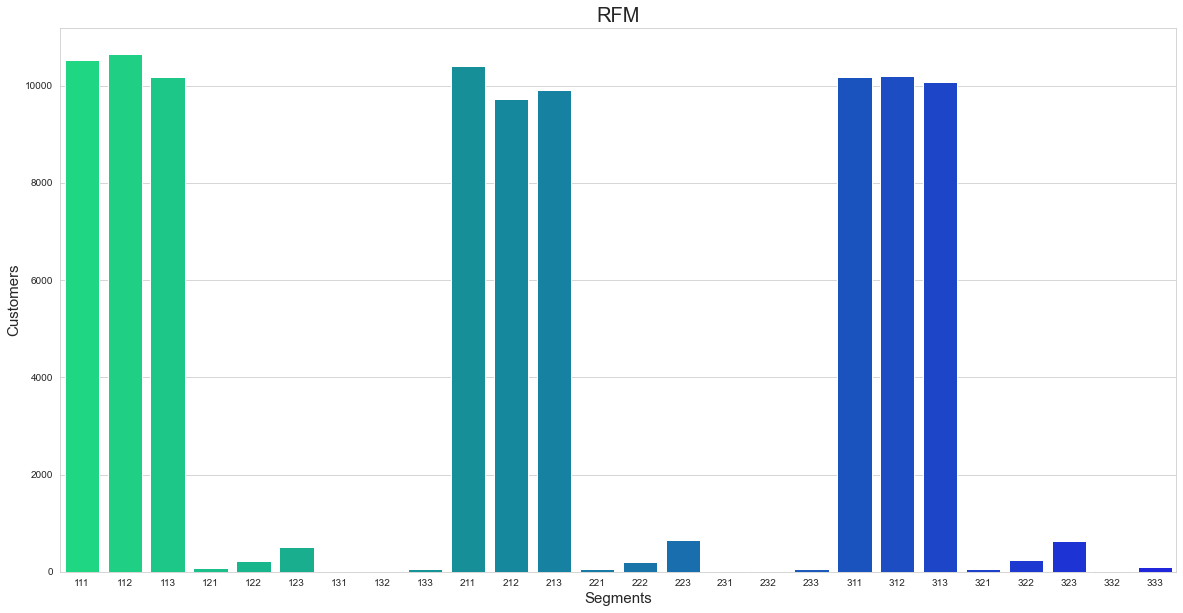

In [36]:
# Немного визуализации
for_plot = cust_rfm\
                    .groupby('rfm', as_index=False)\
                    .agg({'customer': 'count'})

f, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x='rfm', y='customer', data=for_plot, palette='winter_r')
plt.title('RFM', loc='center', fontsize=20)
ax.set_xlabel('Segments', fontsize=15)
ax.set_ylabel('Customers', fontsize=15)

In [37]:
# Добавляем описание сегментов
segt_map = {
            r'11': 'Потерянные',
            r'12': 'Скоро потеряются',
            r'13': 'Можно попробовать удержать',
            r'21': 'Спящие',
            r'22': 'Требующие внимания',
            r'23': 'Лояльные',
            r'21': 'Многообещающие',
            r'31': 'Новые',
            r'32': 'Потенциально лояльные',
            r'33': 'Лучшие'
            }

cust_rfm['segment'] = cust_rfm['r'].map(str) + cust_rfm['f'].map(str)
cust_rfm['segment'] = cust_rfm['segment'].replace(segt_map, regex=True)


C:\Users\525B~1\AppData\Local\Temp/ipykernel_12232/3755988875.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_rfm['segment'] = cust_rfm['r'].map(str) + cust_rfm['f'].map(str)
C:\Users\525B~1\AppData\Local\Temp/ipykernel_12232/3755988875.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_rfm['segment'] = cust_rfm['segment'].replace(segt_map, regex=True)


In [38]:
# В процентном соотношении картина удручающая
cust_rfm.segment.value_counts(normalize=True).mul(100)

Потерянные                    33.092887
Новые                         32.149760
Многообещающие                31.724138
Потенциально лояльные          0.989597
Требующие внимания             0.964250
Скоро потеряются               0.831177
Красавчики                     0.114062
Можно попробовать удержать     0.067593
Лояльные                       0.066536
Name: segment, dtype: float64

Text(0, 0.5, 'Percent')

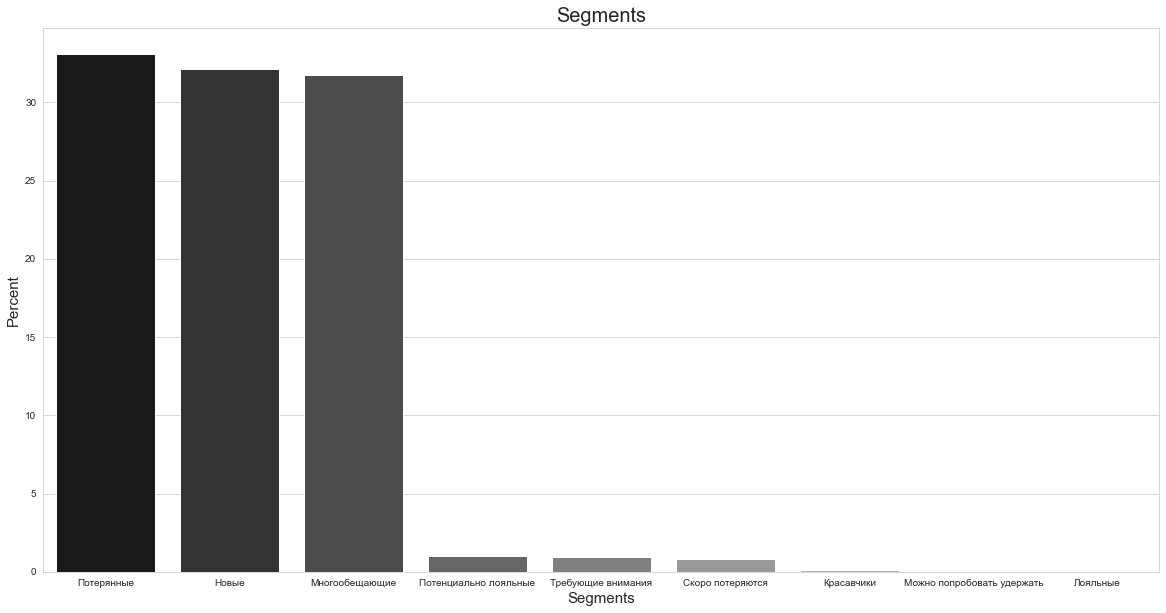

In [39]:
# На графике не лучше, палитру подобрал соответствующую
segm_percentage = cust_rfm\
                           .segment\
                           .value_counts(normalize=True)\
                           .mul(100)\
                           .to_frame()\
                           .reset_index()

f, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x='index', y='segment', data=segm_percentage, palette='gray')
plt.title('Segments', loc='center', fontsize=20)
ax.set_xlabel('Segments', fontsize=15)
ax.set_ylabel('Percent', fontsize=15)
# Есть с чем работать, приток новых клиентов неплохой, и потенциальных постоянников тоже немало, значит реклама работает хорошо
# Нужно разбираться, почему клиенты не переходят в разряд постоянников, а, видимо, 
# уходят на другие платформы после первого заказа

# Дополнение

In [40]:
# Пытался разобраться в причинах такого положения вещей

In [41]:
# Вывел разницы в датах между обещанными и фактическими датами доставки логистическим службам и клиентам
# В логистичекие службы опаздывает примерно 9% заказов, а к клиентам примерно 8%. Есть над чем поработать,
# но в целом не критично.
limit_date = order_items[['order_id', 'shipping_limit_date']].drop_duplicates(subset='order_id')

date_test = orders\
                   .query('order_status == "delivered"')\
                   .merge(
                          limit_date,
                          on='order_id'
                          )

date_test =\
            date_test[[
                'order_id', 
                'order_delivered_carrier_date', 
                'order_delivered_customer_date', 
                'order_estimated_delivery_date', 
                'shipping_limit_date'
              ]]

date_test['shipping_date_diff'] = (date_test.shipping_limit_date - date_test.order_delivered_carrier_date).dt.days
date_test['delivery_date_diff'] = (date_test.order_estimated_delivery_date - date_test.order_delivered_customer_date).dt.days

date_test = date_test[['order_id', 'shipping_date_diff', 'delivery_date_diff']]

a =(date_test.query('shipping_date_diff < 0').shape[0] / date_test.shape[0])*100
b = (date_test.query('delivery_date_diff < 0').shape[0] / date_test.shape[0])*100

print(
f'На стадии передачи заказа партнеру по логистике {round(a, 2)} процентов заказов задерживаются, на стадии доставки клиентам - {round(b, 2)}'
     )

На стадии передачи заказа партнеру по логистике 9.04 процентов заказов задерживаются, на стадии доставки клиентам - 8.11


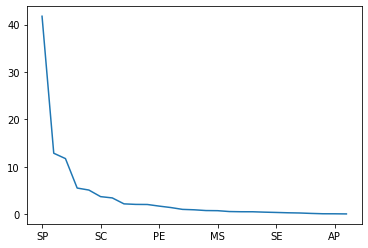

In [100]:
# Попробовал найти какую-то закономерность связанную с местоположением клиентов
# Распределение кол-ва сделавших всего один заказ по штатам примерно совпадает 
# с распределением по штатам всех заказов (ячейка ниже)
# Ну, оно и неудивительно, у нас более 90% клиентов по одному заказу сделали
cust_test = customers\
                      .merge(
                             orders\
                                    .query('order_status in ("processing", "shipped", "delivered")'),
                                    on='customer_id'
                            )

cust_states = cust_test[['customer_unique_id', 'customer_state']].drop_duplicates(subset='customer_unique_id')

cust_test\
          .groupby('customer_unique_id', as_index=False)\
          .agg({'order_id': 'count'})\
          .query('order_id == 1')\
          .merge(cust_states, on='customer_unique_id')\
          .customer_state\
          .value_counts(normalize=True)\
          .mul(100)\
#           .plot()

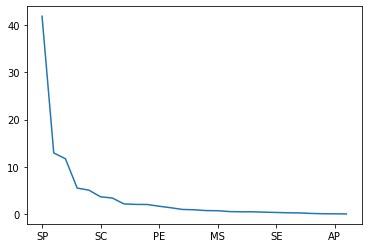

In [101]:
cust_test\
          .customer_state\
          .value_counts(normalize=True)\
          .mul(100)\
#           .plot()

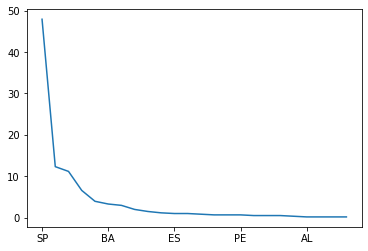

In [99]:
# Заодно проверил, клиенты из каких регионов чаще всего оказываются недоступны, здесь тоже явных аномолий нет
customers\
          .merge(
                 orders\
                        .query('order_status == "unavailable"'),
                        on='customer_id'
                )\
                  .customer_state\
                  .value_counts(normalize=True)\
                  .mul(100)\
                  .plot()

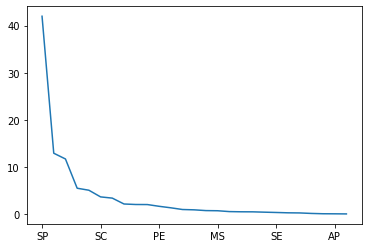

In [98]:
customers\
          .merge(
                 orders,
                        on='customer_id'
                )\
                .customer_state\
                .value_counts(normalize=True)\
                .mul(100)\
                .plot()

In [ ]:
# Возможно, дело в высокой цене или плохом качестве товаров, нужно больше данных